# CommonLit Readability Prize: EDA

#### Reference notebooks
- https://www.kaggle.com/ruchi798/commonlit-readability-prize-eda-baseline

In [1]:
import os
import re
import time
import pathlib
import textstat
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from pandarallel import pandarallel
from pandas_profiling import ProfileReport

from typing import AnyStr

import rich
from rich import print
from rich.theme import Theme
from rich.console import Console

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords

tqdm.pandas()

pandarallel.initialize(progress_bar=True)

plt.style.use('seaborn-darkgrid')

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

%matplotlib inline

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


[nltk_data] Downloading package punkt to /Users/rui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/rui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/rui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rui/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
!ls ../data/raw

commonlitreadabilityprize.zip test.csv
sample_submission.csv         train.csv


In [3]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')
smpl_sub = pd.read_csv('../data/raw/sample_submission.csv')

In [4]:
from sklearn.metrics import mean_squared_error

avg_target = np.tile(train['target'].mean(), (train.shape[0], 1))

rmse_score = mean_squared_error(train['target'], avg_target, squared=False)
print(f'RMSE Score with averaged target: {rmse_score:.4f}')

RMSE Score with averaged target: 1.0334

## Preprocessing excerpt

In [5]:
# # Ref: https://www.kaggle.com/gunesevitan/commonlit-readability-prize-eda
# def clean_text(text):
#     text = re.sub(r'\n', ' ', text)
#     text = re.sub(r'[\.\,]', '', text)
#     text = text.lower()
#     return text

def preprocess_excerpt(text: AnyStr):
    text = re.sub("[^a-zA-Z]", " ", text).lower()
    text = nltk.word_tokenize(text)  # NOTE: 英文を単語分割する
    text = [word for word in text if not word in set(stopwords.words("english"))]
    
    lemma = nltk.WordNetLemmatizer()  # NOTE: 複数形の単語を単数形に変換する
    text =  " ".join([lemma.lemmatize(word) for word in text])
    return text

smpl_excerpt = train['excerpt'].min()
preprocessed_excerpt = preprocess_excerpt(smpl_excerpt)

In [6]:
custom_theme = Theme({
    "info" : "italic bold cyan",
    "warning": "italic bold magenta",
    "danger": "bold red"
})
console = Console(theme=custom_theme)

console.print("Before preprocessing: ", style="info")
console.print(smpl_excerpt, style='warning')

console.print("After preprocessing: ", style="info")
console.print(preprocessed_excerpt, style='warning')

Before preprocessing: 

"'Morning, Jeeves," I said.
"Good morning, sir," said Jeeves. He put the good old cup of tea softly on the table by my 
bed, and I took a refreshing sip. Just right, as usual. Not too hot, not too sweet, not too 
weak, not too strong, not too much milk, and not a drop spilled in the saucer. A most amazing
cove, Jeeves. So dashed competent in every respect. I've said it before, and I'll say it 
again. I mean to say, take just one small instance. Every other valet I've ever had used to 
barge into my room in the morning while I was still asleep, causing much misery: but Jeeves 
seems to know when I'm awake by a sort of telepathy. He always floats in with the cup exactly
two minutes after I come to life. Makes a deuce of a lot of difference to a fellow's day.
"How's the weather, Jeeves?" 
"Exceptionally clement, sir."
"Anything in the papers?"
"Some slight friction threatening in the Balkans, sir. Otherwise, nothing."

After preprocessing: 

morning jeeves said good morning sir said jeeves put good old cup tea softly table bed took 
refreshing sip right usual hot sweet weak strong much milk drop spilled saucer amazing cove 
jeeves dashed competent every respect said say mean say take one small instance every valet 
ever used barge room morning still asleep causing much misery jeeves seems know awake sort 
telepathy always float cup exactly two minute come life make deuce lot difference fellow day 
weather jeeves exceptionally clement sir anything paper slight friction threatening balkan 
sir otherwise nothing

In [7]:
%%time

# NOTE: Apply all train data.
train['excerpt_preprocessed'] = train['excerpt'].parallel_apply(preprocess_excerpt)

CPU times: user 1.47 s, sys: 279 ms, total: 1.75 s
Wall time: 18.2 s


In [8]:
print(train.shape)
train.head()

(2834, 7)

,id,url_legal,license,excerpt,target,standard_error,excerpt_preprocessed
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,young people returned ballroom presented decid...
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,dinner time mr fayre somewhat silent eye resti...
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,roger predicted snow departed quickly came two...
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,outside palace great garden walled round fille...
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,upon time three bear lived together house wood...


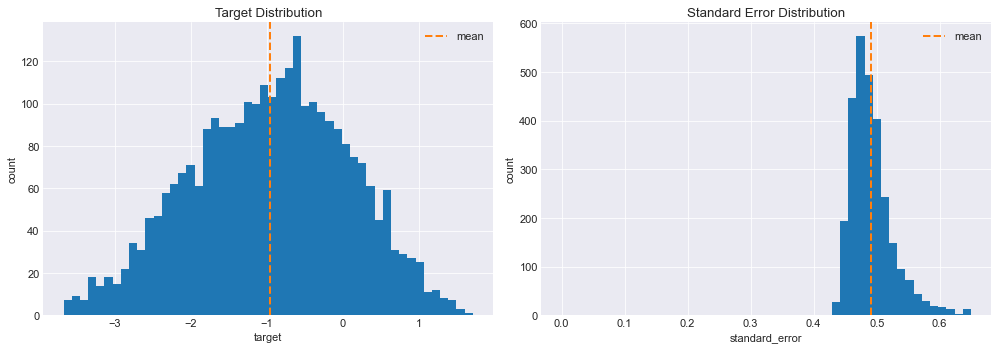

In [9]:
plt.figure(figsize=(14, 5))
plt.rcParams["font.size"] = 11

plt.subplot(121)
plt.title('Target Distribution')
train['target'].hist(bins=50)
plt.axvline(train['target'].mean(), color='tab:orange', linewidth=2, linestyle='--', label='mean')
plt.xlabel('target')
plt.ylabel('count')
plt.legend()

plt.subplot(122)
plt.title('Standard Error Distribution')
train['standard_error'].hist(bins=50)
plt.axvline(train['standard_error'].mean(), color='tab:orange', linewidth=2, linestyle='--', label='mean')
plt.xlabel('standard_error')
plt.ylabel('count')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# NOTE: lexicon = world

# Methods of textstats is below 
# https://github.com/shivam5992/textstat/blob/c422f5b1df8138d2520736dbe1aae0d2782515e0/textstat/textstat.py

# Reference notebook.
# https://www.kaggle.com/gunesevitan/commonlit-readability-prize-eda

train['excerpt_len'] = train['excerpt_preprocessed'].str.len()
train['avg_word_len'] = train['excerpt_preprocessed'].apply(lambda x: [len(s) for s in x.split()]).map(np.mean)
train['char_count'] = train['excerpt'].map(textstat.char_count)
train['word_count'] = train['excerpt_preprocessed'].map(textstat.lexicon_count)
train['sentence_count'] = train['excerpt'].map(textstat.sentence_count)
train['syllable_count'] = train['excerpt'].apply(textstat.syllable_count)
train['smog_index'] = train['excerpt'].apply(textstat.smog_index)
train['automated_readability_index'] = train['excerpt'].apply(textstat.automated_readability_index)
train['coleman_liau_index'] = train['excerpt'].apply(textstat.coleman_liau_index)
train['linsear_write_formula'] = train['excerpt'].apply(textstat.linsear_write_formula)

In [11]:
%%time

train['excerpt_count_difficult_words'] = train['excerpt'].progress_apply(lambda x : textstat.difficult_words(x))

  0%|          | 0/2834 [00:00<?, ?it/s]

CPU times: user 3min 33s, sys: 10.7 s, total: 3min 44s
Wall time: 3min 46s


In [12]:
train['excerpt_raito_difficult_words'] = train['excerpt_count_difficult_words'] / train['word_count']

In [13]:
train.head()

,id,url_legal,license,excerpt,target,standard_error,excerpt_preprocessed,excerpt_len,avg_word_len,char_count,word_count,sentence_count,syllable_count,smog_index,automated_readability_index,coleman_liau_index,linsear_write_formula,excerpt_count_difficult_words,excerpt_raito_difficult_words
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,young people returned ballroom presented decid...,591,5.505495,819,91,11,225,8.6,8.3,8.06,9.000000,25,0.274725
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,dinner time mr fayre somewhat silent eye resti...,551,5.494118,774,85,12,222,8.3,7.2,6.78,7.285714,17,0.200000
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,roger predicted snow departed quickly came two...,527,5.285714,747,84,8,209,10.1,10.1,7.20,14.750000,17,0.202381
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,outside palace great garden walled round fille...,573,5.106383,747,94,5,196,6.7,16.4,8.54,12.500000,14,0.148936
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,upon time three bear lived together house wood...,413,4.594595,577,74,5,170,8.8,11.8,4.83,13.500000,1,0.013514


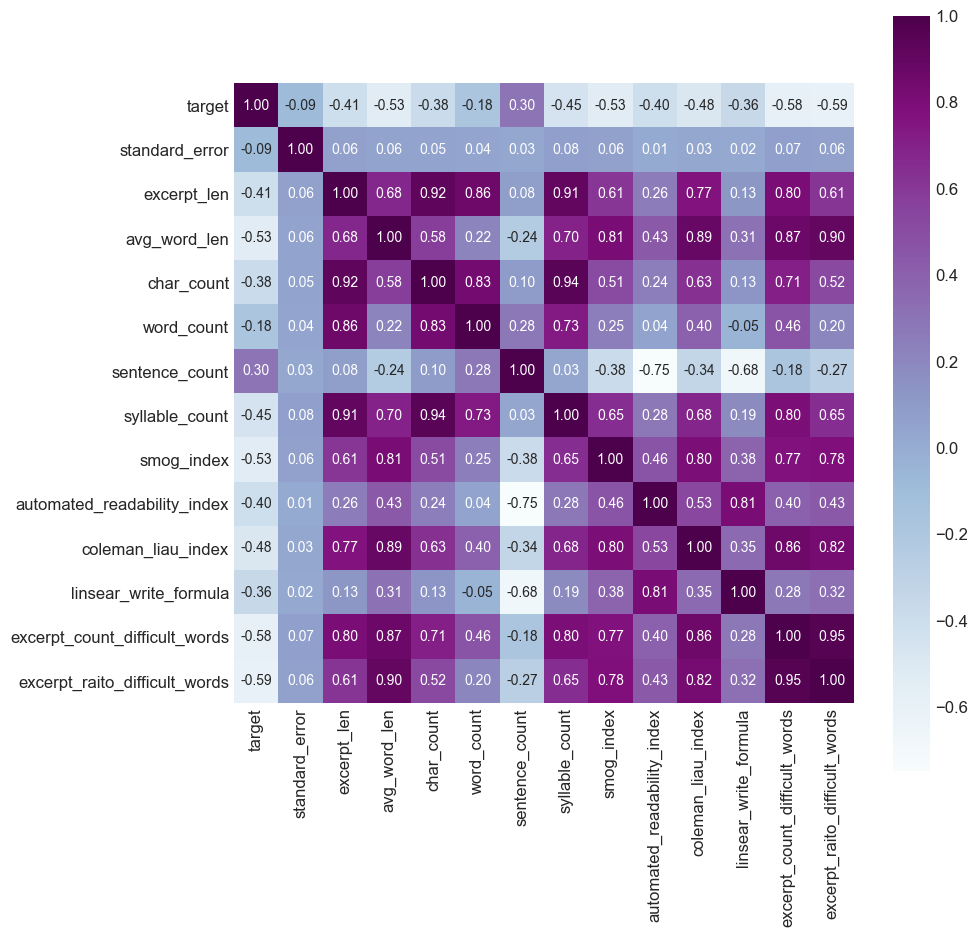

In [14]:
plt.figure(figsize=(10, 10), dpi=100)
plt.rcParams["font.size"] = 12
sns.heatmap(train.corr(), square=True, annot=True, annot_kws={'size': 10}, fmt='.2f', cmap='BuPu')
plt.tick_params(axis='x', labelsize=12, rotation=90)
plt.show()

## Part of speech tagging

In [15]:
def count_tags(pos_tags):
    tag_count = defaultdict(int)
    for word,tag in pos_tags:
        tag_count[tag] += 1
    return dict(tag_count)

In [16]:
%%time

train_pos_tag = train['excerpt_preprocessed'].str.split().map(pos_tag)
train_pos_tag = train_pos_tag.map(count_tags)

CPU times: user 13.1 s, sys: 266 ms, total: 13.4 s
Wall time: 13.5 s


In [17]:
tag_cols = ['IN', 'POS', 'PRP', 'DT', 'FW', 'VBG', 'EX', 'NNP', 'RBS', 'NN',
       'CC', 'WRB', 'JJ', 'MD', 'PRP$', 'CD', 'RP', '$', 'VBN', "''",
       'RBR', 'VBD', 'RB', 'UH', 'SYM', 'WP$', 'NNS', 'PDT', 'TO', 'VBZ',
       'VBP', 'JJR', 'WDT', 'WP', 'VB', 'NNPS', 'JJS']

for tag in tag_cols:
    train[tag] = train_pos_tag.map(lambda x: x.get(tag, 0))

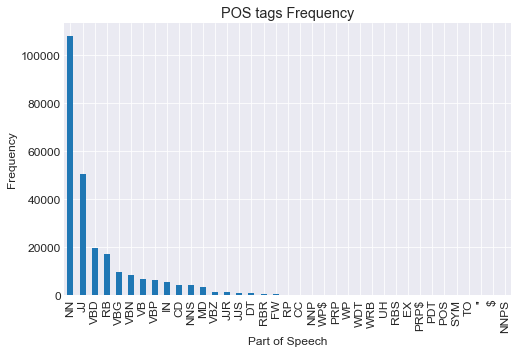

In [18]:
plt.figure(figsize=(8, 5))
plt.title("POS tags Frequency")
train[tag_cols].sum().sort_values(ascending=False).plot(kind='bar')
plt.xlabel("Part of Speech")
plt.ylabel("Frequency")
plt.show()

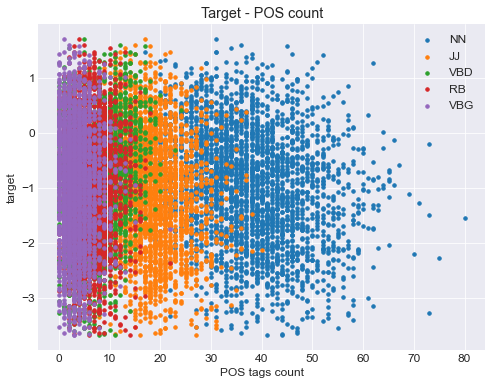

In [19]:
tags = ['NN', 'JJ', 'VBD', 'RB', 'VBG']

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plt.rcParams["font.size"] = 12
plt.title('Target - POS count')
for t in tags:
    ax.scatter(t, 'target', data=train, label=t, s=12)
plt.ylabel('target')
plt.xlabel('POS tags count')
plt.legend()    
plt.show()

## Othre Readability Score

TODO: スコアごとの特徴をまとめたほうがよさそう

- flesch_re: [The Flesch Reading Ease formula](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch_reading_ease)
- flesch_kg: [The Flesch-Kincaid Grade Level](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch_reading_ease)
- fog_scale: [The Fog Scale (Gunning FOG Formula)](https://en.wikipedia.org/wiki/Gunning_fog_index)
- automated_r: [Automated Readability Index](https://en.wikipedia.org/wiki/Automated_readability_index)
- coleman: [The Coleman-Liau Index](https://en.wikipedia.org/wiki/Coleman%E2%80%93Liau_index)
- linsear: [Linsear Write Formula](https://en.wikipedia.org/wiki/Linsear_Write)
- text_standard: Readability Consensus based upon all the above tests

In [20]:
# TODO: 世の中にある readability score を算出する
# https://www.kaggle.com/ruchi798/commonlit-readability-prize-eda-bareadability_colsine?scriptVersionId=62271537&cellId=39

In [21]:
%%time

train['flesch_re'] = train['excerpt_preprocessed'].map(textstat.flesch_reading_ease)

CPU times: user 1.13 s, sys: 10.1 ms, total: 1.14 s
Wall time: 1.14 s


In [22]:
%%time

train['flesch_kg'] = train['excerpt_preprocessed'].map(textstat.flesch_kincaid_grade)

CPU times: user 1.21 s, sys: 15.9 ms, total: 1.23 s
Wall time: 1.25 s


In [23]:
%%time

train['fog_scale'] = train['excerpt_preprocessed'].map(textstat.gunning_fog)

CPU times: user 2min 21s, sys: 4.85 s, total: 2min 26s
Wall time: 2min 26s


In [24]:
%%time

train['automated_r'] = train['excerpt_preprocessed'].map(textstat.automated_readability_index)

CPU times: user 241 ms, sys: 2.82 ms, total: 244 ms
Wall time: 243 ms


In [25]:
%%time

train['coleman'] = train['excerpt_preprocessed'].map(textstat.coleman_liau_index)

CPU times: user 380 ms, sys: 3.29 ms, total: 383 ms
Wall time: 382 ms


In [26]:
%%time

train['linsear'] = train['excerpt_preprocessed'].map(textstat.linsear_write_formula)

CPU times: user 1.24 s, sys: 3.91 ms, total: 1.24 s
Wall time: 1.24 s


In [27]:
%%time

train['text_standard'] = train['excerpt_preprocessed'].map(textstat.text_standard)

CPU times: user 5min 25s, sys: 14.8 s, total: 5min 40s
Wall time: 5min 46s


In [31]:
%%time

train['excerpt_spache_readability'] = train['excerpt'].progress_apply(lambda x: textstat.spache_readability(x))

  0%|          | 0/2834 [00:00<?, ?it/s]

CPU times: user 3min 31s, sys: 10 s, total: 3min 41s
Wall time: 3min 42s


In [32]:
%%time

train['excerpt_dale_chall_readability_score_v2'] = train['excerpt'].progress_apply(lambda x: textstat.dale_chall_readability_score_v2(x))

  0%|          | 0/2834 [00:00<?, ?it/s]

CPU times: user 3min 48s, sys: 13.4 s, total: 4min 1s
Wall time: 4min 7s


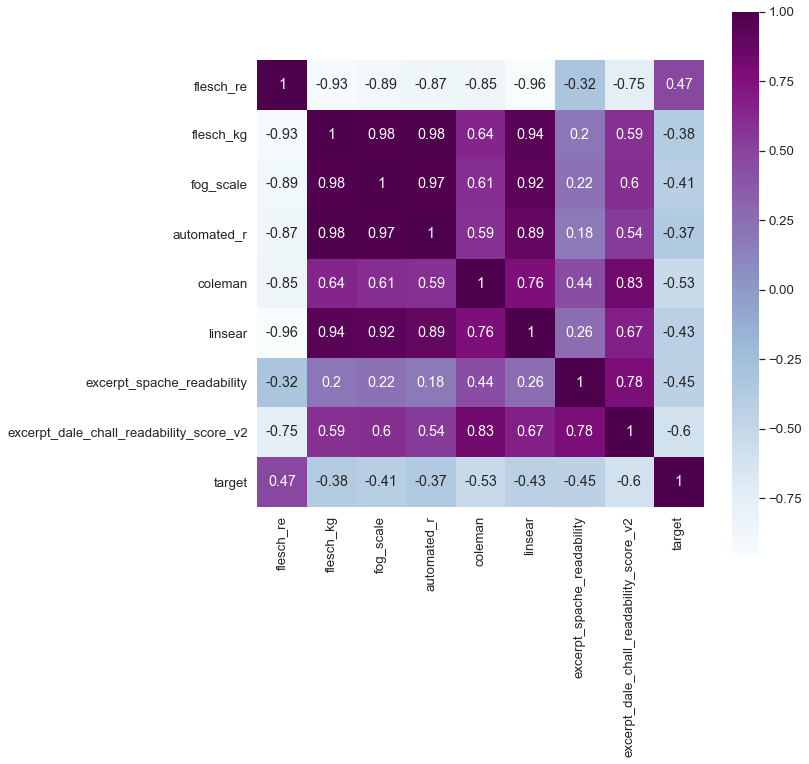

In [33]:
readability_cols = ['flesch_re','flesch_kg','fog_scale','automated_r','coleman','linsear','text_standard', 
                   'excerpt_spache_readability', 'excerpt_dale_chall_readability_score_v2']
readability_cols += ['target']

plt.figure(figsize=(10, 10))
plt.rcParams["font.size"] = 12
sns.set(font_scale=1.2)
sns.heatmap(train[readability_cols].corr(), square=True, annot=True, cmap='BuPu')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


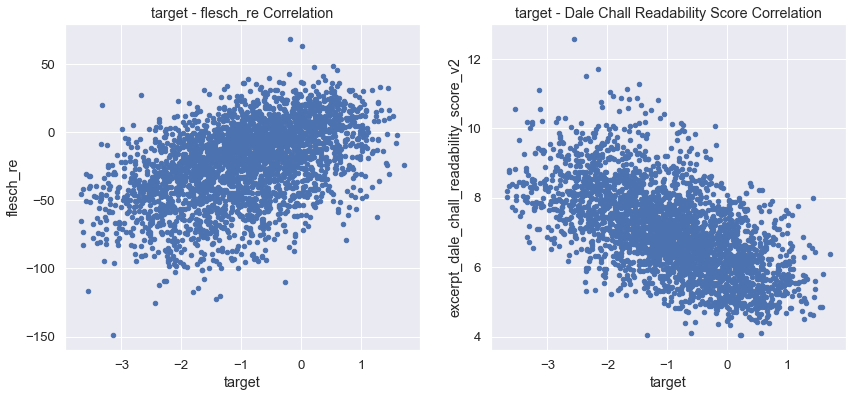

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
plt.rcParams["font.size"] = 12

train.plot(
    kind='scatter', 
    x='target', 
    y='flesch_re', 
    ax=axes[0], 
    title='target - flesch_re Correlation',
)

train.plot(
    kind='scatter', 
    x='target', 
    y='excerpt_dale_chall_readability_score_v2', 
    ax=axes[1], 
    title='target - Dale Chall Readability Score Correlation',
)

plt.show()

## Baseline Model

In [35]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor

In [36]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [37]:
X = train['excerpt_preprocessed']
y = train['target']

model_dict = {
    "Ridge": Ridge(fit_intercept = True, normalize = False),
    "LinearRegression": LinearRegression(),
    "LogisticRegression": LogisticRegression(),
    "RandomForestRegressor": RandomForestRegressor(max_depth=5, min_samples_leaf=20),
}

for model_name, base_model in model_dict.items():
    model = make_pipeline(
        TfidfVectorizer(binary=True, ngram_range=(1,1)),
        base_model,
    )

    result = cross_validate(model, X, y, cv=5, scoring={'rmse': make_scorer(rmse)}, return_train_score=True, n_jobs=-1)
    
    print(model_name)
    print(f"\tfit_time   : {result['fit_time'].mean():.5f}")
    print(f"\tscore_time : {result['score_time'].mean():.5f}")
    print(f"\ttrain_rmse : {result['train_rmse'].mean():.5f}") 
    print(f"\ttest_rmse  : {result['test_rmse'].mean():.5f}") 

Ridge

fit_time   : 0.23652

score_time : 0.04272

train_rmse : 0.39895

test_rmse  : 0.77175

LinearRegression

fit_time   : 0.24262

score_time : 0.04063

train_rmse : 0.00841

test_rmse  : 0.80600

LogisticRegression

fit_time   : 0.27528

score_time : 0.00000

train_rmse : nan

test_rmse  : nan

RandomForestRegressor

fit_time   : 4.67155

score_time : 0.05242

train_rmse : 0.81889

test_rmse  : 0.91829

## Export report generated with pandas-profiling.

In [38]:
profile = ProfileReport(train, title="Pandas Profiling Report", explorative=True)
profile.to_file("report.html")

Summarize dataset:   0%|          | 0/78 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# profile.to_notebook_iframe()